# 导入必要包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import  Dataset,random_split,DataLoader

# 定义绘图函数

In [2]:
def plot_series(time,plot_series,format='-',start=0,end=None,label=None):
    plt.plot(time[start:end],plot_series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

# 数据生成函数的编写

In [3]:
def trend(time,slope=0):
    return (slope * time)
def whtie_noise(time,std=1.0,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*std
# 季节性周期模式
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
def  seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time + phase) % period)/period
    return amplitude * seasonal_pattern(season_time)


# 数据集的生成
## 数据集的划分于batch的生成

In [4]:
def train_test_split(series,split_fraction=0.7):
    train_size = int(len(series) * split_fraction)
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set,test_set
# 将数据集划分为指定的batch 大小
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range (0,num_examples,batch_size):
        #最后一次可能不满足一个batch
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)
    

## 滑动窗口的实现

In [5]:
import random
def data_process(train,test,windows_size):
    # print(train.shape)
    train_tensor = torch.from_numpy(train)
    train_windows_split=train_tensor.unfold(0,windows_size,1)
    train_set = train_windows_split.numpy()

    test_tensor = torch.from_numpy(test)
    test_windows_split=test_tensor.unfold(0,windows_size,1)
    test_set = test_windows_split.numpy()

    #将训练集短序列打乱
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2 = np.array(train_temp1)

    test_temp1 = test_set.tolist()
   
    test_temp2 = np.array(test_temp1)

    # 将短序列划分为 featrue label
    train_feature_array =  train_temp2[:,:windows_size-1]
    train_label_array = train_temp2[:,windows_size-1:]


    test_feature_array = test_temp2[:,:windows_size-1]
    test_label_array = test_temp2[:,windows_size-1:]

    # 将nparray 转为 tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)
    # 扩展数据维度，符合CNN输入
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0],1,train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0],1,test_feature_tensor.shape[1])

    return train_feature,train_label,test_feature,test_label

# 生成虚拟数据集

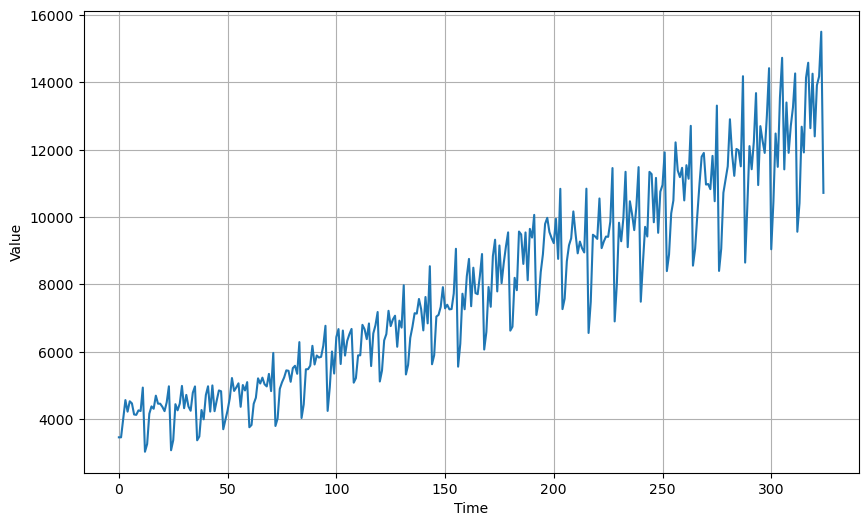

In [6]:
data = pd.read_csv(r'E:\PythonCode\DeepLearning\Time_Series\data\experment_03\alcohol.csv')
series =  data['S4248SM144NCEN'].values
# print(type(series))
time = np.arange(len(series))
series.astype(np.double)
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
split_prop = 0.7
train,test = train_test_split(series,split_prop)
windows_size =  6
# 调用data_process 进行数据处理
train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# 分别输出训练集，测试集的feature和label
batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        self.x = x
#        self.y = y
      

#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]



# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 数据处理

In [8]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# split_prop = 0.7
# train,test = train_test_split(series,split_prop)
# print(test)
# windows_size =  6
# # 调用data_process 进行数据处理
# train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# # 分别输出训练集，测试集的feature和label
# batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        x  = x.to(torch.float32)
#        y  = y.to(torch.float32)
#        self.x = x
#        self.y = y


#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]

# a

# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)



In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
split_prop = 0.7
train,test = train_test_split(series,split_prop)
windows_size =  6
# 调用data_process 进行数据处理
train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# 分别输出训练集，测试集的feature和label
batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        self.x = x
#        self.y = y
      

#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]



# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 定义神经网络

In [10]:
class ConvModel(nn.Module):
   def __init__(self):
       super(ConvModel,self).__init__()
       self.conv1 = nn.Sequential(
           nn.Conv1d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       self.conv2 = nn.Sequential(
           nn.Conv1d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       self.fc1=  nn.Linear(64,128)
       self.fc2 = nn.Linear(128,1)
   def forward(self,x):
    
       out =  self.conv1(x)
       out = F.avg_pool1d(out,2) # 平均池化
       out = self.conv2(out)
       out = F.avg_pool1d(out,2) # 平均池化层
       out = out.squeeze()
       out = self.fc1(out)
       out = self.fc2(out)
       return out




In [11]:
lr = 0.01
epoch = 1000

net = ConvModel()
opt = torch.optim.Adam(net.parameters(), lr=lr)
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)

def loss(x, y):
    return (net(x) - y) ** 2 / 2

train_loss = []
test_loss = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch_num in range(epoch):
    train_list = []
    test_list = []
    for x, y in data_iter(batch_size, train_feature, train_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        if opt is not None:
            opt.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        opt.step()
        train_list.append(l.item())
    for x, y in data_iter(batch_size, test_feature, test_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        test_list.append(l.item())
    test_loss.append(np.mean(test_list))
    train_loss.append(np.mean(train_list))
    print("epoch:", epoch_num + 1,
          "train_loss:", np.mean(test_list),
          "test_loss:", np.mean(train_list))

epoch: 1 train_loss: 64789560.0 test_loss: 22873544.0
epoch: 2 train_loss: 49232204.0 test_loss: 21502243.0
epoch: 3 train_loss: 6105561.0 test_loss: 13413782.5
epoch: 4 train_loss: 16578521.0 test_loss: 3278581.9375
epoch: 5 train_loss: 1890100.625 test_loss: 3482773.375
epoch: 6 train_loss: 9877242.0 test_loss: 1474835.6875
epoch: 7 train_loss: 7063574.0 test_loss: 3394604.25
epoch: 8 train_loss: 1309631.125 test_loss: 1688995.1875
epoch: 9 train_loss: 6523480.0 test_loss: 849665.171875
epoch: 10 train_loss: 1673341.25 test_loss: 1870644.0
epoch: 11 train_loss: 3129822.25 test_loss: 557461.84375
epoch: 12 train_loss: 3887620.75 test_loss: 1247126.4375
epoch: 13 train_loss: 1428672.125 test_loss: 1071224.28125
epoch: 14 train_loss: 2673792.75 test_loss: 464675.40625
epoch: 15 train_loss: 2047676.25 test_loss: 944028.75
epoch: 16 train_loss: 1542365.625 test_loss: 559151.09375
epoch: 17 train_loss: 2311799.5 test_loss: 613844.09375
epoch: 18 train_loss: 1424444.25 test_loss: 697044.5
e

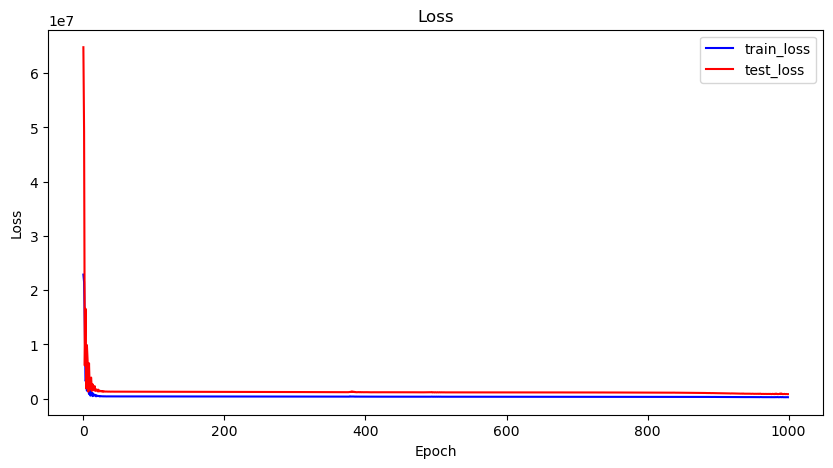

In [12]:
from matplotlib import pyplot as plt
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_loss)), train_loss, 'b-', label="train_loss")
    plt.plot(range(len(train_loss)), test_loss, 'r-', label="test_loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
plot_loss(train_loss,test_loss)

# 模型预测

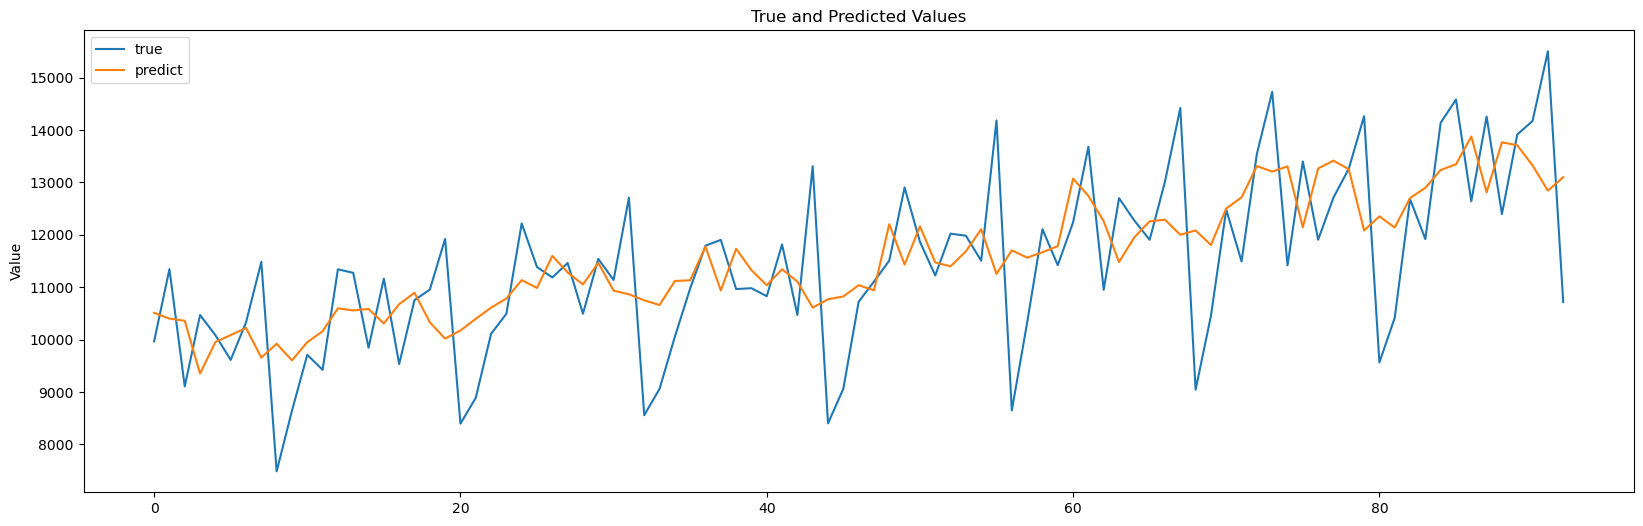

In [13]:
def plot_predictions(net, test_feature, test_label, split_prop, series):
    test_predict = net(test_feature.to(torch.float32).to(device)).squeeze().tolist()
    split_point = int(split_prop * int(series.size))
    test_true = test_label

    plt.figure(figsize=(20, 6))
    plt.plot(test_true, label='true')
    plt.plot(test_predict, label='predict')
    plt.ylabel('Value')
    plt.title('True and Predicted Values')
    plt.legend()
    plt.show()
plot_predictions(net,test_feature,test_label,split_prop,series)

# ResNet实现

In [14]:
import torch.nn as nn
import torchvision.models as models
class ResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet1D, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0), bias=False)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.unsqueeze(3)
        x = self.resnet(x)
        return x


In [15]:
resNet = ResNet1D()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
lr = 0.01
epoch = 1000
patience = 10  # 最大容忍连续多少个 epoch 验证集损失没有下降
best_loss = float('inf')
best_model = None
opt = torch.optim.Adam(resNet.parameters(), lr=lr)

def loss(x, y):
    return (resNet(x) - y) ** 2 / 2

train_loss = []
test_loss = []
no_improvement_count = 0  # 连续多少个 epoch 验证集损失没有下降
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
for epoch_num in range(epoch):
    train_list = []
    test_list = []
    for x, y in data_iter(batch_size, train_feature, train_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        if opt is not None:
            opt.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        opt.step()
        train_list.append(l.item())
    for x, y in data_iter(batch_size, test_feature, test_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        test_list.append(l.item())
    test_loss.append(np.mean(test_list))
    train_loss.append(np.mean(train_list))
    print("epoch:", epoch_num + 1,
          "train_loss:", np.mean(test_list),
          "test_loss:", np.mean(train_list))
    # 如果验证集的损失没有下降，则计数器加 1，否则重置计数器
    if test_loss[-1] >= best_loss:
        no_improvement_count += 1
    else:
        no_improvement_count = 0
        best_loss = test_loss[-1]
        best_model = resNet.state_dict()
    # 如果连续多于 patience 个 epoch 验证集损失没有下降，则停止训练
    if no_improvement_count >= patience:
        print("Early stopping at epoch", epoch_num + 1)
        break

# 加载最佳模型的参数
resNet.load_state_dict(best_model)

epoch: 1 train_loss: 66319548.0 test_loss: 22885293.0
epoch: 2 train_loss: 66129624.0 test_loss: 22782305.0
epoch: 3 train_loss: 65911988.0 test_loss: 22662882.0
epoch: 4 train_loss: 65724052.0 test_loss: 22541641.0
epoch: 5 train_loss: 65505808.0 test_loss: 22421601.0
epoch: 6 train_loss: 65274064.0 test_loss: 22286280.0
epoch: 7 train_loss: 65019220.0 test_loss: 22137962.0
epoch: 8 train_loss: 64750084.0 test_loss: 21978595.0
epoch: 9 train_loss: 64470656.0 test_loss: 21808555.0
epoch: 10 train_loss: 64137944.0 test_loss: 21627247.0
epoch: 11 train_loss: 63810132.0 test_loss: 21443872.0
epoch: 12 train_loss: 63441976.0 test_loss: 21227143.0
epoch: 13 train_loss: 63103224.0 test_loss: 21003500.0
epoch: 14 train_loss: 62857688.0 test_loss: 20778853.0
epoch: 15 train_loss: 62591792.0 test_loss: 20620667.0
epoch: 16 train_loss: 62278188.0 test_loss: 20402175.0
epoch: 17 train_loss: 61735776.0 test_loss: 20130902.0
epoch: 18 train_loss: 61028108.0 test_loss: 19807873.0
epoch: 19 train_los

<All keys matched successfully>

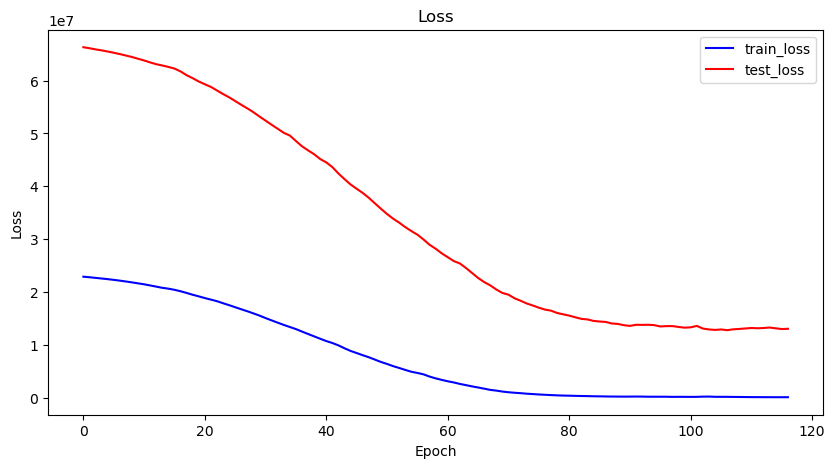

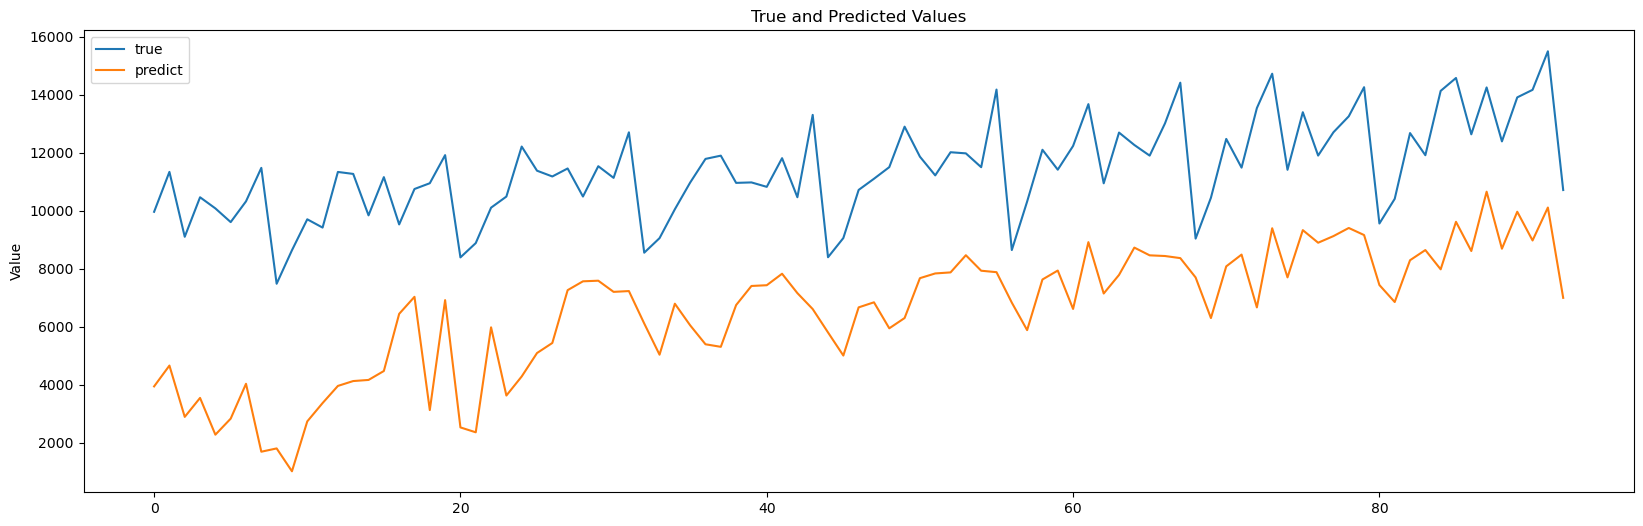

In [16]:
plot_loss(train_loss,test_loss)
plot_predictions(resNet,test_feature,test_label,split_prop,series)